**Uncomment the following lines (by deleting the leading `#`) if you are running this in Colab. (Thanks to Jake VanderPlas for the tip!)**

In [1]:
# !pip install biopython
# !pip install folium
# !curl -O https://raw.githubusercontent.com/jperkel/example_notebook/master/NC_005816.gb

This simple notebook demonstrates how users can interleave text, code, and results in a single document. We start with a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values. The Jupyter notebook allows us to express that mathematically, using the typesetting language $\LaTeX{}$: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

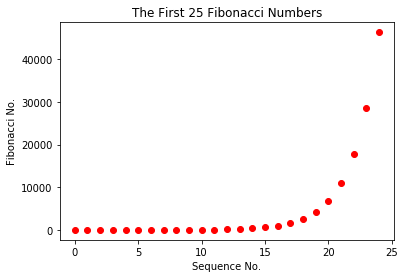

In [5]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
## uncomment the following call to ax.plot() (by removing the leading '#') and select 
## 'Cell > Run All' (in Binder) or 'Run > Run All Cells' (Jupyter) to change the graph below
# ax.plot (range(25), ar)
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

Anything you can do programmatically, can be documented in a notebook. Here we'll do some simple sequence analysis with Biopython. The following example is adapted from the [Biopython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). 

First, we'll read in a Genbank-formatted file, which represents a circular DNA, called a plasmid, from the bacterium, *Yersinia pestis*. 

In [6]:
from Bio import SeqIO

record = SeqIO.read("NC_005816.gb", "genbank")
record.seq

Seq('TGTAACGAACGGTGCAATAGTGATCCACACCCAACGCCTGAAATCAGATCCAGG...CTG', IUPACAmbiguousDNA())

How long is the DNA, and how which genes does it encode?

In [7]:
print("Length:", len(record.seq), "bp")
print("No. features:", len(record.features),"\n")

for i,feat in enumerate (record.features):
    if (feat.type == "CDS"):
        product = feat.qualifiers['product'][0]
        print ("Feat. %d: %s" % (i, product))

Length: 9609 bp
No. features: 41 

Feat. 3: putative transposase
Feat. 8: transposase/IS protein
Feat. 15: putative replication regulatory protein
Feat. 18: hypothetical protein
Feat. 21: pesticin immunity protein
Feat. 23: pesticin
Feat. 29: hypothetical protein
Feat. 32: outer membrane protease
Feat. 35: putative transcriptional regulator
Feat. 38: hypothetical protein


This plasmid encodes 41 features, including 10 genes. Let's focus on feature #18, which encodes a 'hypothetical protein'.

In [8]:
feat = record.features[18]
print ("Gene location\nStart:", feat.location.start, "\nEnd:", feat.location.end)
print ("GeneID:", feat.qualifiers.get("db_xref"))

Gene location
Start: 3485 
End: 3857
GeneID: ['GI:45478715', 'GeneID:2767720']


These data show us that the gene is located between bases 3485 and 3857. Let's retrieve that segment and translate it.

In [9]:
my_gene = record[3485:3857]
print (my_gene.seq.translate(table="Bacterial"))

VSKKRRPQKRPRRRRFFHRLRPPDEHHKNRRSSQRWRNPTGLKDTRRFPPEAPSCALLFRPCRLPDTSPPFSLREAWRFLIAHAVGISVRCRSFAPSWAVCTNPPFSPTTAPYPVTIVLSPTR*


Now, let's find out more about this gene, using the NCBI Entrez database. We learned the accession number above: `GeneID: ['GI:45478715', 'GeneID:2767720']`.

20 May 2020: Updated the following two cells to reflect changes in NCBI's Entrez database. 

In [10]:
from Bio import Entrez
from Bio import SeqIO

In [11]:
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
with Entrez.efetch (db="protein",rettype="gb",retmode="text",id="45478715") as handle:
    print (SeqIO.read(handle, "gb"))
# handle = Entrez.efetch (db="nucleotide",id="45478715",rettype="gb",retmode="text")
# print (handle.read())

ID: NP_995570.1
Name: NP_995570
Description: hypothetical protein YP_pPCP04 (plasmid) [Yersinia pestis biovar Microtus str. 91001]
Database cross-references: BioProject:PRJNA58037
Number of features: 3
/topology=linear
/data_file_division=CON
/date=16-DEC-2014
/accessions=['NP_995570']
/sequence_version=1
/db_source=REFSEQ: accession NC_005816.1
/keywords=['RefSeq']
/source=Yersinia pestis biovar Microtus str. 91001
/organism=Yersinia pestis biovar Microtus str. 91001
/taxonomy=['Bacteria', 'Proteobacteria', 'Gammaproteobacteria', 'Enterobacteriales', 'Enterobacteriaceae', 'Yersinia']
/references=[Reference(title='Genetics of metabolic variations between Yersinia pestis biovars and the proposal of a new biovar, microtus', ...), Reference(title='Complete genome sequence of Yersinia pestis strain 91001, an isolate avirulent to humans', ...), Reference(title='Direct Submission', ...), Reference(title='Direct Submission', ...)]
/comment=PROVISIONAL REFSEQ: This record has not yet been subj

Jupyter also supports interactive data exploration. Here we'll add an interactive map, just as in our June [mapping feature](https://www.nature.com/articles/d41586-018-05331-6) -- something you might do when working with geospatial data. This requires the Python Leaflet library, folium. 

In [12]:
import folium

Now we create a simple map: a few points in London, Oxford and Cambridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). 

In [13]:
coords = { 
    0: { "name": "Nature", "lat": 51.533925, "long": -0.121553 },
    1: { "name": "Francis Crick Institite", "lat": 51.531877, "long": -0.128767 },
    2: { "name": "MRC Laboratory for Molecular Cell Biology", "lat": 51.524435, "long": -0.132495 },
    3: { "name": "Kings College London", "lat": 51.511573, "long": -0.116083 },
    4: { "name": "Imperial College London", "lat": 51.498780, "long": -0.174888 },
    5: { "name": "Cambridge University", "lat": 52.206960, "long": 0.115034 },
    6: { "name": "Oxford University", "lat": 51.754843, "long": -1.254302 },
    7: { "name": "Platform 9 3/4", "lat": 51.532349, "long": -0.123806 }
}

In [14]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for key in coords.keys():
    folium.CircleMarker(
    location=[coords[key]['lat'], coords[key]['long']],
    popup=coords[key]['name'],
    color=('crimson' if coords[key]['name'] == 'Nature' else 'blue'),
    fill=False,
    ).add_to(m)

# pull in the Macrostrat tile layer
folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map. **Note that this map is interactive**: you can zoom, pan, click the points of interest, and alternate between the two layers (by clicking on the tiles icon in the upper-right corner of the map). If you click anywhere on the map, a popup will appear showing the latitude and longitude of that position.

In [15]:
m

Document our session, for [computational reproducibility](https://www.nature.com/articles/d41586-018-05990-5)!

In [16]:
import IPython
print(IPython.sys_info())

{'commit_hash': '8bda98619',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/opt/anaconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.12.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.7.0-x86_64-i386-64bit',
 'sys_executable': '/opt/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.6 (default, Jan  8 2020, 13:42:34) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}


In [17]:
!pip freeze | grep -E 'folium|matplotlib|biopython'

biopython==1.76
folium==0.11.0
matplotlib==3.1.3
